In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Scanning Astra evaluations

In [2]:
from astra import template_dir, evaluate_astra_with_distgen

import matplotlib.pyplot as plt

import numpy as np
import os

In [3]:
# Input files
ASTRA_IN = os.path.join(template_dir, 'dcgun/astra.in')
DISTGEN_IN = os.path.join(template_dir, 'dcgun/distgen.yaml')

In [4]:
# Run Astra with Distgen

# Basic settings
settings0 = {'zstop':1, 'zemit':10, 'zphase':10, 'phases':True}
settings0['distgen:n_particle'] = 2000

# Solenoid field
settings0['maxb(1)'] = 0.04

In [5]:
# This is the basic function we will use
outputs = evaluate_astra_with_distgen(settings0, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN)
outputs

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': -8.1128e-11,
 'end_sigma_x': 0.00034241,
 'end_sigma_xp': 0.00058502,
 'end_norm_emit_x': 1.7516000000000001e-07,
 'end_cov_x__xp': 1.72026784e-07,
 'end_mean_y': 5.7747e-09,
 'end_sigma_y': 0.00034245,
 'end_sigma_yp': 0.0005843,
 'end_norm_emit_y': 1.7455e-07,
 'end_cov_y__yp': 1.7197839e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 0.0021695000000000004,
 'end_sigma_energy': 1.7883,
 'end_norm_emit_z': 0.0038791,
 'end_cov_z__energy': 7.779827000000001e-05,
 'end_n_particle_loss': 0,
 'end_total_charge': 9.999999999999999e-11,
 'end_higher_order_energy_spread': 1.7879755915303117,
 'fingerprint': '7ac7934708bb59990c053cacfacce879'}

In [6]:
# Make a bare minimum function to evaluate
def f(b):
    s = settings0.copy()
    s['maxb(1)'] = b
    return evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                          distgen_input_file=DISTGEN_IN)
# Make a list to scan
blist = np.linspace(0, 0.1, 20)
f(0)

{'error': False,
 'end_mean_z': 1.0,
 'end_mean_t': 4.0156e-09,
 'end_mean_x': -3.6051e-09,
 'end_sigma_x': 0.0006159000000000001,
 'end_sigma_xp': 0.00065659,
 'end_norm_emit_x': 1.7486999999999998e-07,
 'end_cov_x__xp': 3.9120120300000003e-07,
 'end_mean_y': -5.7092e-09,
 'end_sigma_y': 0.00061615,
 'end_sigma_yp': 0.00065711,
 'end_norm_emit_y': 1.7486e-07,
 'end_cov_y__yp': 3.917050395e-07,
 'end_mean_kinetic_energy': 499790.0,
 'end_sigma_z': 0.0021695000000000004,
 'end_sigma_energy': 1.7883,
 'end_norm_emit_z': 0.0038791,
 'end_cov_z__energy': 7.776355800000001e-05,
 'end_n_particle_loss': 0,
 'end_total_charge': 9.999999999999999e-11,
 'end_higher_order_energy_spread': 1.7879772250915187,
 'fingerprint': '5b0804fd12e8efab9fd2d86ebb66c47e'}

In [7]:
# Get a parallel executor

# Processes. These lines are needed to get this to work on macOS
import multiprocessing as mp                                                                                     
mp.set_start_method("fork")    
from concurrent.futures import ProcessPoolExecutor as Executor

#from concurrent.futures import ThreadPoolExecutor as Executor # DO NOT USE
#from dask.distributed import Client as Executor

executor=Executor()

In [8]:
# Make a map object. Note that this does not execute immediately.
results = executor.map(f, blist)

In [9]:
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)
#    outputs.append(r.result())

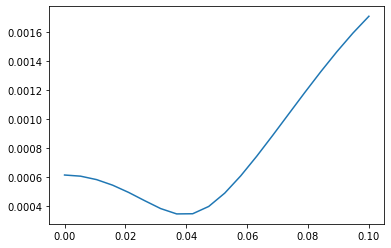

In [10]:
# Simple plot
plt.plot(blist, [o['end_sigma_x'] for o in outputs])

# Better: robust evaluation, form dataset 

In [11]:
from tempfile import TemporaryDirectory
SCRATCH=TemporaryDirectory()

In [12]:
# Make a robust evaluate
def evaluate(b):
    try:
        s = settings0.copy()
        s['maxb(1)'] = b
        output = evaluate_astra_with_distgen(s, astra_input_file=ASTRA_IN,
                              distgen_input_file=DISTGEN_IN, archive_path=SCRATCH.name)
        # Add the input
        output['maxb(1)'] = b
        output['Exception'] = False
    except:
        output = {}
        output['maxb(1)'] = b
        output['Exception'] = True
        
    return output

In [13]:
SCRATCH.name

'/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpi2mvu5dq'

In [14]:
# This will cause a crash in Astra
evaluate(1e9)

Run Aborted too many indices for array: array is 1-dimensional, but 2 were indexed


{'maxb(1)': 1000000000.0, 'Exception': True}

In [15]:
# Get a new executor
executor =  Executor()

# Make a map object. Note that this does not execute immediately.

blist[-1] = 1e9 # Add something that will crash
results = executor.map(evaluate, blist)
# Actually evalute the funciton and gather the results
outputs = []
for r in results:
    outputs.append(r)

Run Aborted too many indices for array: array is 1-dimensional, but 2 were indexed


In [16]:
# Archive files are here
os.listdir(SCRATCH.name)

['64b91ee131b660a51ab9e4bd1b027dba.h5',
 'bf5ed66c92a1072cdeca37160764e102.h5',
 '489de9814446951e760967bfcf8ecf90.h5',
 '7fe5e615657ad7df1ffac0f72d9b77de.h5',
 '4113c5646d3e0c3055cb1c876eb208a4.h5',
 '9db7e6b8191da6467bd174030c56c168.h5',
 'a1412a1fd2ffba684dd641dc5f8509f3.h5',
 'f1feeb54ad61398b29ff4c53e14cc379.h5',
 '2d99ab26148e64093a62e4b39410049e.h5',
 'f3770fd580fea0e298cce35b6017ef2a.h5',
 '2c6a6d46e2221017edf6bf504f5a3d9e.h5',
 '91e15d4dd895199d256cfccbaaf8b0c1.h5',
 '9d86f1b8df92acd4061081b62111358a.h5',
 'b510376be8a6fa9b5a6d93ae1634b45d.h5',
 'a45f5c278e90512c758e4c423311693a.h5',
 'b47bbafdb3a10bcdc09f7bceaaed1f63.h5',
 'c6f67641a0e223578029a27e3e7482a2.h5',
 '4185232b0a67ce9e552c25894a90e6b9.h5',
 'e4b11971c2d089fe55f0ccd5a0151fa0.h5']

# Pandas 

In [17]:
import pandas as pd

In [18]:
# Make a DataFrame
df = pd.DataFrame(outputs)
df

,error,end_mean_z,end_mean_t,end_mean_x,end_sigma_x,end_sigma_xp,end_norm_emit_x,end_cov_x__xp,end_mean_y,end_sigma_y,...,end_sigma_energy,end_norm_emit_z,end_cov_z__energy,end_n_particle_loss,end_total_charge,end_higher_order_energy_spread,fingerprint,archive,maxb(1),Exception
0,False,1.0,4.015600e-09,-3.605100e-09,0.000616,0.000657,1.748700e-07,3.912012e-07,-5.709200e-09,0.000616,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787977,4113c5646d3e0c3055cb1c876eb208a4,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,0.000000e+00,False
1,False,1.0,4.015600e-09,-2.727100e-09,0.000608,0.000647,1.749400e-07,3.799807e-07,-5.900700e-09,0.000608,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787977,9d86f1b8df92acd4061081b62111358a,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,5.263158e-03,False
2,False,1.0,4.015600e-09,-1.654600e-09,0.000584,0.000621,1.750100e-07,3.477970e-07,-5.564700e-09,0.000584,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787977,bf5ed66c92a1072cdeca37160764e102,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.052632e-02,False
3,False,1.0,4.015600e-09,-5.596500e-10,0.000546,0.000581,1.750700e-07,2.999282e-07,-4.652900e-09,0.000545,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787977,c6f67641a0e223578029a27e3e7482a2,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,1.578947e-02,False
4,False,1.0,4.015600e-09,3.749800e-10,0.000496,0.000535,1.751200e-07,2.448360e-07,-3.170800e-09,0.000495,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787976,4185232b0a67ce9e552c25894a90e6b9,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.105263e-02,False
5,False,1.0,4.015600e-09,9.793000e-10,0.000439,0.000499,1.751500e-07,1.935768e-07,-1.156600e-09,0.000439,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787976,2d99ab26148e64093a62e4b39410049e,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,2.631579e-02,False
6,False,1.0,4.015600e-09,1.098900e-09,0.000384,0.000492,1.751700e-07,1.589409e-07,1.296300e-09,0.000384,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787976,7fe5e615657ad7df1ffac0f72d9b77de,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.157895e-02,False
7,False,1.0,4.015600e-09,5.689600e-10,0.000347,0.000534,1.751700e-07,1.545434e-07,4.052900e-09,0.000347,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787976,f3770fd580fea0e298cce35b6017ef2a,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,3.684211e-02,False
8,False,1.0,4.015600e-09,-6.653800e-10,0.000349,0.000629,1.751500e-07,1.937603e-07,6.928300e-09,0.000349,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787976,489de9814446951e760967bfcf8ecf90,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.210526e-02,False
9,False,1.0,4.015600e-09,-2.662300e-09,0.000399,0.000768,1.751300e-07,2.886720e-07,9.753800e-09,0.000399,...,1.7883,0.003879,0.000078,0.0,1.000000e-10,1.787976,b47bbafdb3a10bcdc09f7bceaaed1f63,/var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn...,4.736842e-02,False


In [19]:
# Get all runs without an exeption
filtered_df=df[~df['Exception']]

# Visualize with Bokeh

In [20]:
from bokeh.plotting import figure, output_notebook, show

from bokeh.models import ColumnDataSource

# Allows plots to show up in the notebook
output_notebook()

Loading BokehJS ...

In [21]:
# Form a Bokeh style data source
source = ColumnDataSource(filtered_df)
source.column_names

['index',
 'error',
 'end_mean_z',
 'end_mean_t',
 'end_mean_x',
 'end_sigma_x',
 'end_sigma_xp',
 'end_norm_emit_x',
 'end_cov_x__xp',
 'end_mean_y',
 'end_sigma_y',
 'end_sigma_yp',
 'end_norm_emit_y',
 'end_cov_y__yp',
 'end_mean_kinetic_energy',
 'end_sigma_z',
 'end_sigma_energy',
 'end_norm_emit_z',
 'end_cov_z__energy',
 'end_n_particle_loss',
 'end_total_charge',
 'end_higher_order_energy_spread',
 'fingerprint',
 'archive',
 'maxb(1)',
 'Exception']

In [22]:
# A simple plot
p = figure()
p.circle(x='maxb(1)', y='end_sigma_x', source=source)
show(p)

In [23]:
# Fancier plot

from bokeh.models.tools import HoverTool

hover = HoverTool()


hover.tooltips=[
    ('sigma_x', '@end_sigma_x'),
    ('norm_emit_x', '@end_norm_emit_x'),
    ('archive', '@archive')
]
p = figure(tools='tap')
p.circle(x='maxb(1)', y='end_sigma_x', source=source, size=10, color='green')

p.add_tools(hover)

show(p)

In [24]:
# Load all archives
from astra import Astra
Alist = []
for a in filtered_df['archive']:
    A = Astra()
    A.load_archive(a)
    Alist.append(A)

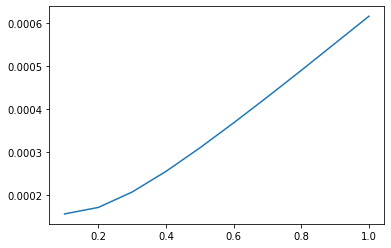

In [25]:
plt.plot(
    Alist[0].output['stats']['mean_z'],
    Alist[0].output['stats']['sigma_x']
)